In [ ]:
#create barplot showing mean expression in each condition/developmental stage for each gene group

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# #make directory for the plots to be exported to
# dirName = f'../../data/output/{args.file_names}/genes/{args.output_folder_name}'
# try:
#     # Create target Directory
#     os.mkdir(dirName)
#     print("Directory " , dirName ,  " created") 
# except FileExistsError:
#     print("Directory " , dirName ,  " already exists")

In [13]:
gene_groups_cv='/home/witham/Documents/pipeline_new/PromoterArchitecture/data/output/non-overlapping_includingbidirectional_all_genes_newannotation/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
gene_groups_tau='/home/witham/Documents/pipeline_new/PromoterArchitecture/data/output/non-overlapping_includingbidirectional_all_genes_newannotation/genes/promoters_5UTR_schmid_non-specific_tissuespecific_random.txt'
expression_data='/home/witham/Documents/pipeline_new/PromoterArchitecture/data/genes/AtGeneExpress_CV_2020/AtGE_dev_gcRMA.txt.newline'

In [134]:
def prepare_files(expression_data, gene_groups_cv, gene_groups_tau):
    """read in files and create dfs"""
    expression_data_df = pd.read_table(expression_data, sep='\t',header=0)
    cvgroups_df = pd.read_table(gene_groups_cv, sep='\t',header=None)
    taugroups_df = pd.read_table(gene_groups_tau, sep='\t',header=None)
    
    #add column names
    cols = ['AGI code','gene_type']
    cvgroups_df.columns = cols
    taugroups_df.columns = cols
    
    #remove control categories
    cvgroups_df_filtered = cvgroups_df[~(cvgroups_df.gene_type == 'control')]
    taugroups_df_filtered = taugroups_df[~(taugroups_df.gene_type == 'control')]
    
     #remove NaN in AGI code column
    expression_data_df = expression_data_df.dropna()
    #remove Affy_identifier that starts with AFFX (Affymetrix normalisation probes)
    expression_data_df2 = expression_data_df[~expression_data_df.Affy_identifier.str.startswith('AFFX')]
    
    #set gene name as index column
    expression_data_df2.set_index('AGI code',inplace=True)
        
    #merge columns that are replicates
    #first make a list of all final column names
    list_of_conditions = []
    for col in expression_data_df2.columns:
        if col == 'Affy_identifier':
            pass
        else:
            

            if col[:-2] in list_of_conditions:
                pass
            else:
                list_of_conditions.append(col[:-2])
    
    #create copy of df
    mean_replicates = expression_data_df2.copy()
    #merge replicates and calculate the mean
    for ID in list_of_conditions:
        tempdf= mean_replicates.loc[:,mean_replicates.columns.str.contains(ID)].mean(axis=1).reset_index()
        tempdf.columns = ['AGI code', ID]
        #merge with original df
        expression_data_df2 = pd.merge(expression_data_df2, tempdf, how='left', on='AGI code')

    #remove Affy_identifier column
    expression_data_df2.drop('Affy_identifier', inplace=True, axis=1)
    
    #set index
    expression_data_df2.set_index('AGI code', inplace=True)
    
    #select only columns in the list
    expression_data_df2 = expression_data_df2[[name for name in list_of_conditions]]    
    
    #Filter genes which have no expression
    expression_data_df3 = expression_data_df2.loc[(expression_data_df2 > 0).any(axis=1)]

    ###make separate df of conditions/tissue gene expression containing only genes from each gene_type category###
    
    #concatenate the gen_type dfs
    four_gene_types = pd.concat([cvgroups_df_filtered,taugroups_df_filtered])
    
    #reset index of expression data
    expression_data_df3.reset_index(level=0, inplace=True)

    #make expression_data_df3 AGI's upper case

    expression_data_df3['AGI code'] = expression_data_df3['AGI code'].str.upper()
    
    #merge dfs so only genes in each category are included    
    gene_type_expression_data = pd.merge(four_gene_types, expression_data_df3, how='left',on='AGI code')
    

    #melt df into long format
    gene_type_expression_data_long = pd.melt(gene_type_expression_data, id_vars=['AGI code','gene_type'], value_vars=gene_type_expression_data.columns[2:],var_name='condition/tissue',value_name='mean_log2_expression')
    
    return gene_type_expression_data_long,gene_type_expression_data

In [103]:
def makeplot(gene_type_expression_data_long):
    plot = sns.catplot(x='condition/tissue',y="mean_log2_expression", hue="gene_type",
                 col="gene_type", data=gene_type_expression_data)
    

In [111]:
# def makeheatmap(gene_type_expression_data):
#     """make a heatmap"""
#     #set index
#     gene_type_expression_data_index = gene_type_expression_data.set_index('gene_type')
#     #drop AGI column
#     gene_type_expression_data_index.drop(['AGI code'],axis=1,inplace=True)
#     ax = sns.heatmap(gene_type_expression_data_index)

In [205]:
def makeheatmap(gene_type_expression):
    """make a heatmap - input data into long table format"""
   # gene_type_expression_data_index = gene_type_expression_data.set_index('gene_type')
    #drop AGI column
    #gene_type_expression_dropped = gene_type_expression.drop(['gene_type'],axis=1)
    #group by gene type
    #grouped = gene_type_expression.groupby('gene_type').reset_index()
    #return grouped
    #pivot df
    #keep only one condition    
    #change font size
    sns.set(font_scale=1.5)
    f,(ax1,ax2,ax3,ax4, axcb) = plt.subplots(1,5, 
            gridspec_kw={'width_ratios':[1,1,1,1,0.08]})
    
    f.set_size_inches(12, 5)
    ax1.get_shared_y_axes().join(ax2,ax3,ax4)
    g1 = sns.heatmap(gene_type_expression[gene_type_expression.gene_type=='constitutive'].pivot("AGI code","condition/tissue", "mean_log2_expression"),cmap="YlGnBu",cbar=False,ax=ax1)
    g1.set_ylabel('Genes (n=100)')
    g1.set_title('Constitutive', weight='bold')
    g1.set_xlabel('Condition/tissue')
    g1.set_xticks([])
    g1.set_yticks([])
    g2 = sns.heatmap(gene_type_expression[gene_type_expression.gene_type=='variable'].pivot("AGI code","condition/tissue", "mean_log2_expression"),cmap="YlGnBu",cbar=False,ax=ax2)
    g2.set_ylabel('')
    g2.set_title('Variable', weight='bold')
    g2.set_xlabel('Condition/tissue')
    g2.set_yticks([])
    g2.set_xticks([])
    g3 = sns.heatmap(gene_type_expression[gene_type_expression.gene_type=='non-specific'].pivot("AGI code","condition/tissue", "mean_log2_expression"),cmap="YlGnBu",cbar=False,ax=ax3)
    g3.set_ylabel('')
    g3.set_title('Non-specific', weight='bold')
    g3.set_xlabel('Condition/tissue')
    g3.set_yticks([])
    g3.set_xticks([])
    g4 = sns.heatmap(gene_type_expression[gene_type_expression.gene_type=='tissue_specific'].pivot("AGI code","condition/tissue", "mean_log2_expression"),cmap="YlGnBu",ax=ax4, cbar_ax=axcb)
    g4.set_ylabel('')
    g4.set_title('Tissue_specific', weight='bold')
    g4.set_xlabel('Condition/tissue')
    g4.set_xticks([])
    g4.set_yticks([])

    #set key label 
    axcb.set_ylabel("Mean log2 expression")

    # may be needed to rotate the ticklabels correctly:
    for ax in [g1,g2,g3,g4]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl, rotation=90)
        tly = ax.get_yticklabels()
        ax.set_yticklabels(tly, rotation=0) 
        
    
    #gene_type_expression = gene_type_expression[gene_type_expression.gene_type=='constitutive'].pivot("AGI code","condition/tissue", "mean_log2_expression")
    
    #ax = sns.heatmap(gene_type_expression)

In [185]:
gene_type_expression_data_long,gene_type_expression_data = prepare_files(expression_data,gene_groups_cv, gene_groups_tau)

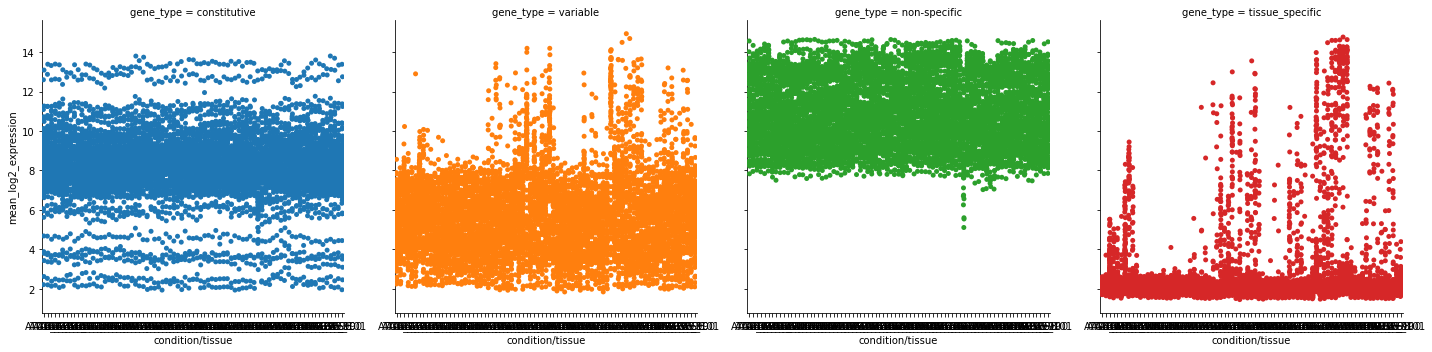

In [104]:
makeplot(gene_type_expression_data_long)

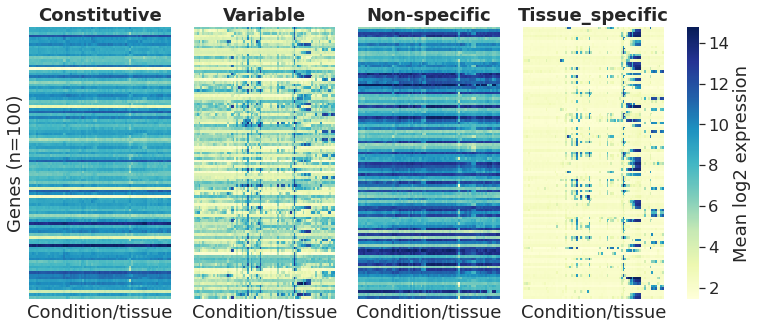

In [206]:
makeheatmap(gene_type_expression_data_long)